### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 1000  # upper limit of integral # 5
nbit = 10  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 3.289861639787202e-06
Discretized Result: 3.2898585023210548e-06


In [3]:
import sys
sys.path.append('../libmitigation')

In [4]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt 
import random
random.seed(10)

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [5]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from sgs_algorithm import sgs_algorithm

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


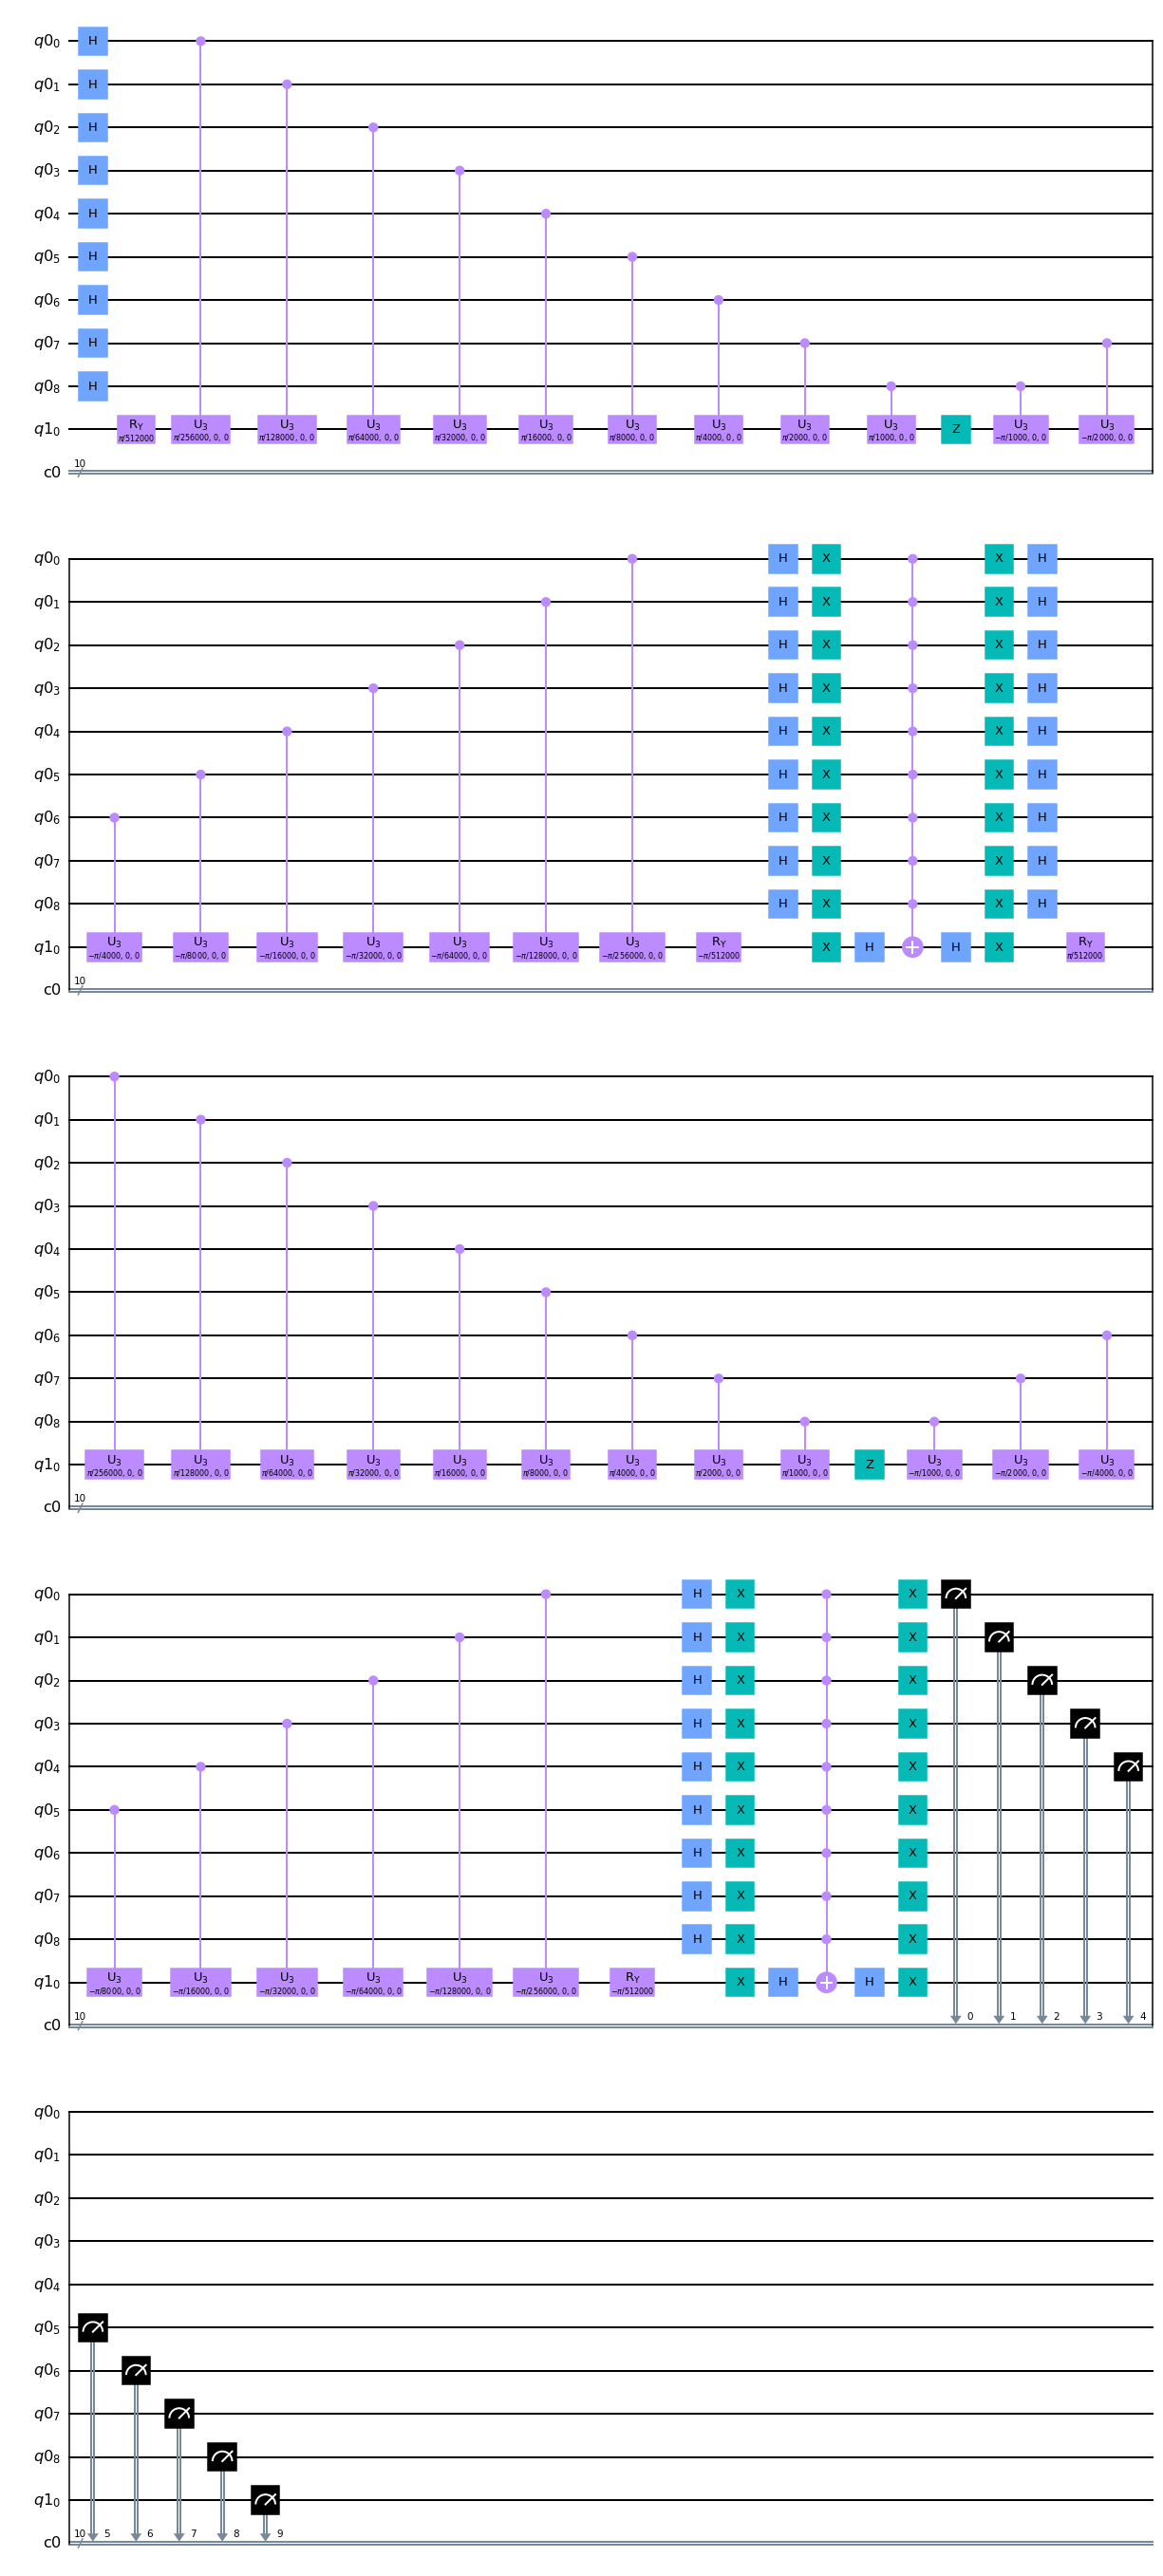

In [8]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [11]:
#setting the number of shots and Grover operators.

number_grover_list = [0, 1, 2, 4, 8, 16, 32, 64, 128]  # list of number of Grover operators
# number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [12]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.91, 0.09],[0.09,0.91]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [13]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [14]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
0.7492668628692627 s
1 th round with 1 oracles
0.02836298942565918 s
2 th round with 2 oracles
0.020975828170776367 s
3 th round with 3 oracles
0.029519081115722656 s
4 th round with 4 oracles
0.03758096694946289 s
5 th round with 5 oracles
0.04729795455932617 s
6 th round with 6 oracles
0.05044293403625488 s
7 th round with 7 oracles
0.05727219581604004 s
8 th round with 8 oracles
0.07060694694519043 s
9 th round with 9 oracles
0.0740809440612793 s
10 th round with 10 oracles
0.07575511932373047 s
11 th round with 11 oracles
0.07236075401306152 s
12 th round with 12 oracles
0.07253694534301758 s
13 th round with 13 oracles
0.09444093704223633 s
14 th round with 14 oracles
0.10022211074829102 s
15 th round with 15 oracles
0.10169386863708496 s
16 th round with 16 oracles
0.10811281204223633 s
17 th round with 17 oracles
0.11378884315490723 s
18 th round with 18 oracles
0.1267850399017334 s
19 th round with 19 oracles
0.145294189453125 s
20 th round with 20 ora

In [15]:
import pickle
with open("raw_result_p009_q009_piover1000.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [16]:
import pickle
with open("raw_result_p009_q009_piover1000.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [17]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[27, 44, 45, 43, 38, 38, 41, 39, 50, 42, 46, 44, 45, 44, 43, 38, 38, 44, 43, 37, 38, 42, 48, 41, 34, 44, 36, 41, 40, 36, 33, 42, 33, 47, 41, 39, 35, 40, 34, 39, 44, 50, 28, 30, 36, 39, 46, 41, 43, 35, 34, 31, 36, 33, 51, 32, 38, 34, 39, 43, 37, 30, 41, 40, 32, 35, 45, 39, 37, 39, 37, 32, 34, 33, 34, 43, 43, 31, 35, 38, 28, 35, 44, 35, 34, 35, 28, 33, 31, 32, 39, 34, 37, 40, 38, 39, 37, 25, 42, 30]


In [19]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [20]:
meas_filter = InvSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
mit_counts_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    mit_counts_list.append(x_tilde)
mit_hit_list = make_hit_list(mit_counts_list)

strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999993
number of positive values:  523
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000013
number of positive values:  510
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999999
number of positive values:  502
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999996
number of positive values:  507
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999991
number of positive values:  506
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000004
number of positive values:  498
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999974
number of positive values:  499
main process: Done!
strict invers

sum of mitigated probability vector x: 0.9999999999999997
number of positive values:  506
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000013
number of positive values:  508
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999979
number of positive values:  508
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000029
number of positive values:  509
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999989
number of positive values:  514
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000007
number of positive values:  521
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000018
number of positive values:  519
main process: Done!
strict inverse + SGS algorithm
sum of mitiga

In [21]:
meas_filter = InvSSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_list.append(x_tilde)
mit_hit_S_list = make_hit_list(x_tilde_S_list)
print(mit_hit_S_list)

Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.7319887637799607
number of positive values:  32
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.351562528062788
number of positive values:  20
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.4119704987721682
number of positive values:  19
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.4512111876991338
number of positive values:  28
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.502915067874931
number of positive values:  27
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.4635791223588372
number of positive values:  25
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector

sum of mitigated probability vector x_s: 1.5141025573100382
number of positive values:  31
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.5418660445692702
number of positive values:  32
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.4713903853064925
number of positive values:  26
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.3959009668853053
number of positive values:  22
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.4964850532710148
number of positive values:  27
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.6217645396830866
number of positive values:  26
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.430644204325
number of positive v

In [22]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.7319887637799607
sum of mitigated probability vector x_hat_s: 1.7319847757942952
number of positive values:  32
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.351562528062788
sum of mitigated probability vector x_hat_s: 1.351522087524376
number of positive values:  20
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4119704987721682
sum of mitigated probability vector x_hat_s: 1.4119734014322232
number of positive values:  19
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4512111876991338
sum of mitigated probability vector x_hat_s: 1.4511864889756716
number of positive values:  28
main process: Done!
Restriction to labels of y + Lagrange Mult

sum of mitigated probability vector x_s: 1.4446817496439044
sum of mitigated probability vector x_hat_s: 1.4446632660397076
number of positive values:  29
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.5886426313591342
sum of mitigated probability vector x_hat_s: 1.5886283064788964
number of positive values:  26
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4728415563108839
sum of mitigated probability vector x_hat_s: 1.4728373831724109
number of positive values:  28
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4171859356758751
sum of mitigated probability vector x_hat_s: 1.417195817611049
number of positive values:  24
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 

sum of mitigated probability vector x_s: 1.507628193830879
sum of mitigated probability vector x_hat_s: 1.507605483479487
number of positive values:  33
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.5755416745110613
sum of mitigated probability vector x_hat_s: 1.5755120617099163
number of positive values:  30
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.6107677505586802
sum of mitigated probability vector x_hat_s: 1.6107507208840577
number of positive values:  29
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4118632985233817
sum of mitigated probability vector x_hat_s: 1.4118490510093067
number of positive values:  22
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1

In [23]:
import pickle
with open("hit_list_p009_q009_piover1000.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [24]:
import pickle
with open("mit_hit_list_p009_q009_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_list, f)

In [25]:
import pickle
with open("mit_hit_S_list_p009_q009_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_S_list, f)

In [26]:
import pickle
with open("mit_hit_S_lm_0_list_p009_q009_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

Text(0, 0.5, 'number of shots for $|00...0>$')

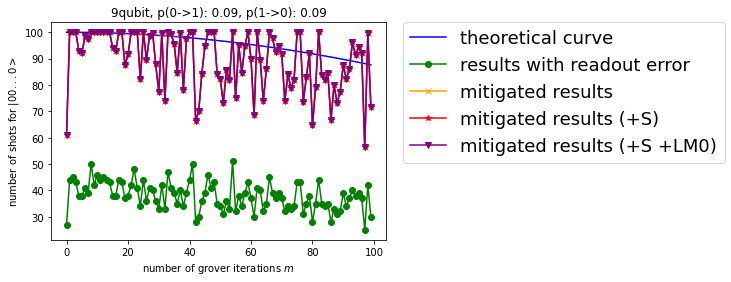

In [27]:
divide = 100
# plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, 100 * np.cos(2 * np.array(number_grover_list) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_list, marker="x", label="mitigated results", color="orange")
plt.plot(number_grover_list, mit_hit_S_list, marker="*", label="mitigated results (+S)", color="red")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("9qubit, p(0->1): 0.09, p(1->0): 0.09")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

In [28]:
def CalcErrorCramérRao(M, shot_list, p0, number_grover_list):
    """
        calculate Cramér-Rao lower bound
            M: upper limit of the sum in Fisher information 
            shots_list:  list of number of shots
            p0: the true parameter value to be estimated
            numebr_grover_list: list of number of Grover operators        

        Return:
            square root of Cramér-Rao lower bound:  lower bound on the standard deviation of unbiased estimators
    """
    FisherInfo = 0
    for k in range(M + 1):
        Nk = shot_list[k]
        mk = number_grover_list[k]
        FisherInfo += Nk / (p0 * (1 - p0)) * (2 * mk + 1)**2
    return np.sqrt(1 / FisherInfo)


def CalcNumberOracleCalls(M, shot_list, number_grover_list):
    """
        calculate the total number of oracle calls
            M: upper limit of the sum in Fisher information 
            shots_list:  list of number of shots
            numebr_grover_list: list of number of Grover operators        

        Return:
            Norac: the total number of oracle calls
    """
    Norac = 0
    for k in range(M + 1):
        Nk = shots_list[k]
        mk = number_grover_list[k]
        Norac += Nk * (2 * mk + 1)
    return Norac

def calculate_theta(hit_list, number_grover_list, shots_list):
    """
        calculate optimal theta values
            hit_list: list of count of obserbving "1" for qc_list
            numebr_grover_list: list of number of Grover operators        
            shots_list: list of number of shots

        Return:
            thetaCandidate_list: list of optimal theta
    """

    small = 1.e-15  # small valued parameter to avoid zero division
    confidenceLevel = 5  # confidence level to determine the search range

    thetaCandidate_list = []
    rangeMin = 0.0 + small
    rangeMax = 1.0 - small
    for igrover in range(len(number_grover_list)):

        def loglikelihood(p): # search value
            ret = np.zeros_like(p)
            theta = np.arcsin(np.sqrt(p)) # search theta
            for n in range(igrover + 1):
                ihit = hit_list[n] # empirical value
                arg = (2 * number_grover_list[n] + 1) * theta # search angle
                ret = ret + 2 * ihit * np.log(np.abs(np.sin(arg))) + 2 * (
                    shots_list[n] - ihit) * np.log(np.abs(np.cos(arg))) # search log likelihood
            return -ret

        searchRange = (rangeMin, rangeMax)
        searchResult = optimize.brute(loglikelihood, [searchRange])
        pCandidate = searchResult[0]
        thetaCandidate_list.append(np.arcsin(np.sqrt(pCandidate)))
        perror = CalcErrorCramérRao(igrover, shots_list, pCandidate, number_grover_list)
        rangeMax = min(pCandidate+confidenceLevel*perror,1.0 - small)
        rangeMin = max(pCandidate-confidenceLevel*perror,0.0 + small)
    return thetaCandidate_list

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in arcsin


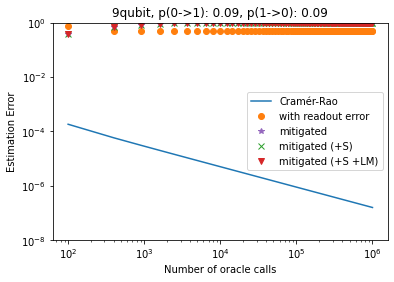

In [29]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_list = [100 - h for h in mit_hit_list]
sin_mit_hit_S_list = [100 - h for h in mit_hit_S_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_list = calculate_theta(
    sin_mit_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_list = calculate_theta(
    sin_mit_hit_S_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_list = np.abs(np.sin(thetaCandidate_mit_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_list = np.abs(np.sin(thetaCandidate_mit_S_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

p = plt.plot( OracleCall_list, ErrorCramérRao_list)
p0 = plt.plot( OracleCall_list, error_list, 'o')
p1 = plt.plot( OracleCall_list, error_mit_list, '*', color='C4')
p2 = plt.plot( OracleCall_list, error_mit_S_list, 'x', color='C2')
p3 = plt.plot( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3')

plt.title("9qubit, p(0->1): 0.09, p(1->0): 0.09")
plt.xscale('log')
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.yscale('log')
plt.ylabel("Estimation Error")
plt.legend((p[0], p0[0], p1[0], p2[0], p3[0]), ("Cramér-Rao", "with readout error", "mitigated", "mitigated (+S)", "mitigated (+S +LM)"))
plt.show()

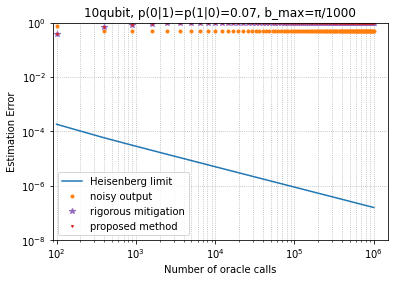

In [30]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p1 = plt.loglog( OracleCall_list, error_mit_list, '*', color='C4', markersize=6)
# p2 = plt.plot( OracleCall_list, error_mit_S_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)

plt.title("10qubit, p(0|1)=p(1|0)=0.09, b_max=π/1000")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p1[0], p3[0]), ("Heisenberg limit", "noisy output", "rigorous mitigation", "proposed method"))
plt.show()